In [5]:
# 1 - EXPLORAÇÃO DA BASE DE DADOS
import glob
import cv2
import matplotlib.pyplot as plt

# Método que exibe imagens das classes que serão apresentadas na próxima célula
def show_multiple_imgs_plt(images_array, titles_array, fig_size=(15, 15), show_axis=False):
    # Determinar o número de linhas e colunas
    num_rows = len(images_array)
    num_cols = len(images_array[0]) if num_rows > 0 else 0
    
    # Criar a figura e os eixos
    _, axis = plt.subplots(num_rows, num_cols, figsize=fig_size)
    
    # Garantir que 'axis' seja sempre uma lista de listas
    if num_rows == 1:
        axis = [axis]
    if num_cols == 1:
        axis = [[ax] for ax in axis]

    # Exibir as imagens
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axis[i][j]
            ax.imshow(images_array[i][j])
            ax.set_anchor('NW')
            ax.set_title(titles_array[i][j], fontdict={'fontsize': 15, 'fontweight': 'medium'}, pad=10)
            if not show_axis:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

Número de imagens saudáveis: 100
Número de imagens doentes: 100


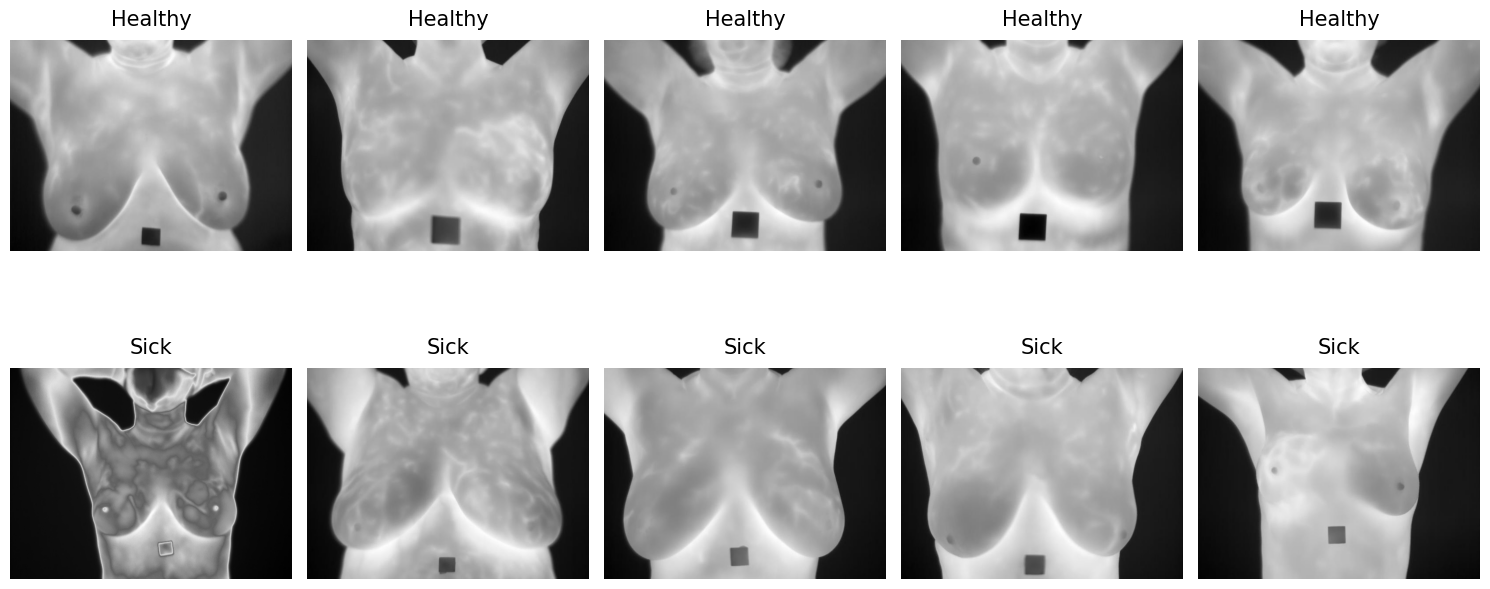

In [6]:
# 1 - EXPLORAÇÃO DA BASE DE DADOS

# A base de dados utilizada é a DMR-IR, que contém imagens termográficas das mamas coletadas pelo
# Laboratório Visual para Pesquisa em Mastologia da Universidade Federal Fluminense (UFF) 
# em Niterói, Brasil. As imagens foram capturadas usando uma câmera térmica FLIR SC620 e possuem 
# resolução de 480 x 640 pixels. A base de dados inclui três classes de imagens: healthy (saudáveis),
# sick (doentes), e unknown (desconhecidas) de pacientes numerados de 1 a 287. Para este projeto, 
# foram usadas apenas imagens das classes "healthy" e "sick".

# Relevância para o Treinamento do Modelo: A classificação de interesse neste projeto é entre
# "saudável" (healthy) e "doente" (sick). A classe "unknown" contém imagens de casos que não 
# foram diagnosticados ou não possuem uma classificação clara, o que poderia introduzir ruído 
# e incerteza nos dados de treinamento, dificultando a aprendizagem do modelo e a interpretação 
# dos resultados.

# Optou-se por baixar as imagens em escala de cinza devido à natureza da análise termográfica, 
# onde a variação de temperatura é o foco principal. As imagens em escala de cinza facilitam a 
# interpretação dos dados térmicos, removendo a complexidade que pode ser introduzida por 
# imagens coloridas.

# Definindo o caminho da base de dados
# Ao baixar as imagens do site http://visual.ic.uff.br/dmi/, as separei em duas pastas diferentes
# uma para as classificadas como healthy.
ROOT_PATH = "D:/Unifesp/IA/termografia/termography/dataset"
healthy_data_path  = ROOT_PATH + "/healthy/"
sick_data_path     = ROOT_PATH + "/sick/"

# Carregando lista dos caminhos da imagens de cada classe
healthy_list = glob.glob(healthy_data_path + '*.jpg')
sick_list    = glob.glob(sick_data_path + '*.jpg')

# Analisando a base de dados
print(f"Número de imagens saudáveis: {len(healthy_list)}")
print(f"Número de imagens doentes: {len(sick_list)}")


# Exibindo algumas imagens das classes "healthy" e "sick"
n_imgs = 4

imgs_healthy   = [cv2.imread(x) for x in healthy_list[:n_imgs+1]]
labels_healthy = ['Healthy' for x in healthy_list[:n_imgs+1]]

imgs_sick   = [cv2.imread(x) for x in sick_list[:n_imgs+1]]
labels_sick = ['Sick' for x in sick_list[:n_imgs+1]]

imgs   = imgs_healthy + imgs_sick
labels = labels_healthy + labels_sick

show_multiple_imgs_plt([imgs[:5], imgs[5:]], [labels[:5], labels[5:]], fig_size = (15,8), show_axis=False)

In [8]:
# 2 - LIMPEZA DOS DADOS
# Conforme mencionadoa anteriormente, as imagens tiveram que ser baixadas uma a uma, logo
# parte do trabalho foi selecionar no site da base de dados as imagens que fossem frontais
# e com classificação healthy ou sick, já que ununknown não é interessante tanto para o treinamento
# quanto validação.

# Função para limpar e redimensionar imagens que não estejam no tamanho informado pela base dados ou corrompidas
def preprocess_image(img, size=(640, 480)):
    # Verificar se a imagem foi carregada corretamente
    if img is None:
        return None
    # Redimensionar a imagem
    img_resized = cv2.resize(img, size)
    return img_resized

# Lendo as imagens em escala de cinza, já que as cores não são pertinentes para o treinamento da rede, uma vez que
# a termografia pode ser analisada em apenas uma camada da imagem sendo onde está mais claro são regiões mais quentes
# e mais escuro regiões mais frias.
healthy_list = [preprocess_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)) for x in healthy_list]
sick_list = [preprocess_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)) for x in sick_list]

# Removendo imagens que não foram carregadas corretamente
healthy_list = [img for img in healthy_list if img is not None]
sick_list = [img for img in sick_list if img is not None]

print(f"Imagens saudáveis após limpeza: {len(healthy_list)}")
print(f"Imagens doentes após limpeza: {len(sick_list)}")

Imagens saudáveis após limpeza: 100
Imagens doentes após limpeza: 100


In [1]:
# 3 - FORMATAÇÃO DOS DADOS PARA UTILIZAÇÃO PELO ALGORITMO DE APRENDIZAGEM
import os
import random
random.seed(1234)

def get_subfolders_dictionary(root_path):
    images_list = []
    labels_dict = {}
    current_label = 0

    for subfolder in os.listdir(root_path):
        if os.path.isdir(os.path.join(root_path, subfolder)):
            images = [image for image in os.listdir(os.path.join(root_path, subfolder)) if image.endswith(('.jpg'))]
            for img in images:

                # Gerando um número único para cada nome da pasta de imagens
                if subfolder in labels_dict:
                    label = labels_dict[subfolder]
                else:
                    label = current_label
                    labels_dict[subfolder] = label
                    current_label += 1

                # Lista irá conter dicionário com o nome da subpasta, nome da imagem e o label dela (int)
                images_list.append({"subfolder": subfolder, "img": img, "label": label})
    return images_list


def split_dataset(images_list, train_ratio=0.8):

    # Embaralhar os caminhos das imagens
    random.shuffle(images_list)

    # Calcular o tamanho do conjunto de treinamento
    num_train = int(len(images_list) * train_ratio)

    # Dividir os caminhos das imagens em conjuntos de treinamento e teste
    train_set = images_list[:num_train]
    test_set = images_list[num_train:]

    return train_set, test_set

In [2]:
# Imports:
from __future__ import print_function, division

import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import time
import os
from PIL import Image

d:\tools\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Clear cuda cache before starting:
torch.cuda.empty_cache()
cudnn.benchmark = True

class CustomImageDataset(Dataset):
    def __init__(self, images_list, root_path, transform=None):
        self.images_list = images_list
        self.transform = transform
        self.root_path = root_path

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_path, self.images_list[idx]['subfolder'], self.images_list[idx]['img'])
        image = Image.open(img_name).convert('RGB')
        label = self.images_list[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

def resnet18_data_preprocessing(images_list, root_path, batch_size=32, workers=2, device='cuda:0'):
    # Define the standard size for ResNet18
    RESNET18_RESIZE = 100
    RESNET_NORMALIZE_VALUES = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Compose data transformations:
    data_transforms = transforms.Compose([
        transforms.Resize((RESNET18_RESIZE, RESNET18_RESIZE)),
        transforms.ToTensor(),
        transforms.Normalize(*RESNET_NORMALIZE_VALUES)
    ])

    # Create datasets
    train_dataset = CustomImageDataset(images_list[0], root_path, transform=data_transforms)
    test_dataset = CustomImageDataset(images_list[1], root_path, transform=data_transforms)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

    # Dataset sizes and class names
    dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
    class_names = list(set(img['label'] for img in images_list[0] + images_list[1]))

    # Config device
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    return {'train': train_loader, 'test': test_loader}, dataset_sizes, class_names, device

In [4]:
# Preparação dos dados
root_path = ROOT_PATH
images_list = get_subfolders_dictionary(root_path)
train_dataset, test_dataset = split_dataset(images_list)

# Carregamento dos dados
data_loaders, dataset_sizes, class_names, device = resnet18_data_preprocessing([train_dataset, test_dataset], root_path, batch_size=8, workers=0, device='cuda:0')

print("Dataset sizes:", dataset_sizes)
print("Class names:", class_names)
print(data_loaders)

Dataset sizes: {'train': 160, 'test': 40}
Class names: [0, 1]
{'train': <torch.utils.data.dataloader.DataLoader object at 0x00000128D61AD880>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x00000128D61ADCA0>}


In [5]:
def train_model(model, dataloaders, dataset_sizes, device, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Torch training loop:
    '''

    # Start timer
    since = time.time()
    print('#################################################################################')
    print(f'Start training model:')
    print('#################################################################################')

    # Loop through number of epochs
    for epoch in range(num_epochs):
        print('#################################################################################')
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('#################################################################################')

        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data in dataloaders
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward and backward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Update loss statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Update learning rate with scheduler
        scheduler.step()

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']

        # Iteration output
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


    # Training iteration loop completed
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    
    return model

In [6]:
from torchvision import models
from torch.optim import lr_scheduler

import torch.nn as nn
import torch.optim as optim

learning_rate  = 0.00045
momentum       = 0.9
lr_decay_gamma = 0.1
lr_decay_step  = 7
save_path      = root_path + "/resnet18"
num_epochs     = 10


# ResNet18  Fit Config:
model_ft    = models.resnet18(pretrained=True)
num_ftrs    = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft    = model_ft.to(device)
criterion   = nn.CrossEntropyLoss()

# Parameters optimization:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)

# Learning Rate Decay by a factor of gamma every step_size epochs:
lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=lr_decay_step, gamma=lr_decay_gamma)


In [7]:
# Training, model fit:
model_ft = train_model(model_ft,
                       data_loaders,
                       dataset_sizes,
                       device, 
                       criterion, 
                       optimizer_ft, 
                       lr_scheduler, 
                       num_epochs)

#################################################################################
Start training model:
#################################################################################
#################################################################################
Epoch 0/9
#################################################################################
Train Loss: 0.5426 Acc: 0.7375
#################################################################################
Epoch 1/9
#################################################################################
Train Loss: 0.2636 Acc: 0.8938
#################################################################################
Epoch 2/9
#################################################################################
Train Loss: 0.2118 Acc: 0.9062
#################################################################################
Epoch 3/9
#################################################################################
Train Loss: 0.1495 Acc: 0

In [8]:
def infer_model(model, data_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Desabilita o cálculo do gradiente para economia de memória
        for inputs, labels in data_loader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcula a precisão
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels

In [9]:
from sklearn.metrics import accuracy_score

def infer_model(model, data_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Desabilita o cálculo do gradiente para economia de memória
        for inputs, labels in data_loader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcula a precisão
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels

model_ft = model_ft.to(device)  # Move o modelo para o dispositivo

# Realiza a inferência
test_accuracy, test_preds, test_labels = infer_model(model_ft, data_loaders, device)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Opcional: mostra algumas predições
for i in range(len(test_preds)):
    print(f'Image {i+1} - Predicted: {test_preds[i]}, Actual: {test_labels[i]}')


Test Accuracy: 87.50%
Image 1 - Predicted: 1, Actual: 0
Image 2 - Predicted: 0, Actual: 0
Image 3 - Predicted: 1, Actual: 1
Image 4 - Predicted: 1, Actual: 1
Image 5 - Predicted: 1, Actual: 0
Image 6 - Predicted: 1, Actual: 1
Image 7 - Predicted: 0, Actual: 0
Image 8 - Predicted: 0, Actual: 1
Image 9 - Predicted: 1, Actual: 1
Image 10 - Predicted: 0, Actual: 0
Image 11 - Predicted: 0, Actual: 0
Image 12 - Predicted: 1, Actual: 1
Image 13 - Predicted: 1, Actual: 1
Image 14 - Predicted: 0, Actual: 0
Image 15 - Predicted: 1, Actual: 1
Image 16 - Predicted: 0, Actual: 0
Image 17 - Predicted: 1, Actual: 1
Image 18 - Predicted: 0, Actual: 0
Image 19 - Predicted: 1, Actual: 1
Image 20 - Predicted: 1, Actual: 1
Image 21 - Predicted: 1, Actual: 1
Image 22 - Predicted: 1, Actual: 1
Image 23 - Predicted: 1, Actual: 1
Image 24 - Predicted: 0, Actual: 0
Image 25 - Predicted: 1, Actual: 1
Image 26 - Predicted: 0, Actual: 0
Image 27 - Predicted: 0, Actual: 0
Image 28 - Predicted: 0, Actual: 0
Image 2